In [1]:
###############################################################
###    solution to the Gorilla Data Engineer Assessment     ###
###############################################################


######### Question 1 #########

import pandas as pd
import numpy as np

Data_main = pd.read_excel('C:/Files/Software/assesment data engi/gorilla_test_data.xlsx',sheet_name = ['meter_list','forecast_table','rate_table'], engine='openpyxl')
result = pd.DataFrame()

#### Find total consumption per meter ####
forecast_table = Data_main['forecast_table']
result = forecast_table[['meter_id','kwh']].groupby(['meter_id']).sum()

#### Find total cost per meter ####
# Create table with info on rates, where NA is filled in with the maximum #
rate_table_full = pd.merge(
    left=Data_main['meter_list'],
    right=Data_main['rate_table'],
    left_on='exit_zone',
    right_on='exit_zone',
    how='outer'
)

# We add 1 for boundry reasons
maxAQ = (Data_main['meter_list']['aq_kwh']).max()+1
rate_table_full = rate_table_full.fillna(value = {"aq_max_kwh": maxAQ}).dropna().reset_index(drop = True)

indexToDrop = np.where(np.less(rate_table_full['aq_kwh'], rate_table_full['aq_min_kwh']) | np.less_equal(rate_table_full['aq_max_kwh'],rate_table_full['aq_kwh']))
rate_table_full = rate_table_full.drop(index=indexToDrop[0]).reset_index(drop = True)

#### assumption ####
# Remark that potential efficiency gain can be obtained if there is a structure in the way ranges of the aq_min_kwh and aq_max_kwh for each day an meter are structed.
# We assumed that this was not the case for sake of generality

# We add 1 day for boundry reasons
maxDate = forecast_table['date'].max() + pd.to_timedelta(1, unit='D') 

# These ranges will never be consulted #
# When merging, it is crucial to limit the dimensions of the table in order to ensure efficiency 
rate_table_full = rate_table_full.drop(index =  np.where(np.less(maxDate,rate_table_full['date']))[0]).reset_index(drop = True)

# Create the start & end_date #
rate_table_full.rename(columns={'date': 'date_start'}, inplace = True)
rate_table_full['date_end'] = rate_table_full['date_start'].shift(-1)
rate_table_full.loc[np.where(rate_table_full['date_end'] == np.datetime64('2020-04-01'))[0],'date_end'] = maxDate
rate_table_full.fillna(value = {'date_end': maxDate}, inplace = True)

forecast_table_full = pd.merge(
    left= forecast_table,
    right= rate_table_full,
    left_on=['meter_id'],
    right_on=['meter_id'],
    how = 'left'
)

indexToDrop = np.where(np.less(forecast_table_full['date'], forecast_table_full['date_start']) | np.less_equal(forecast_table_full['date_end'],forecast_table_full['date']))
forecast_table_full = forecast_table_full.drop(index=indexToDrop[0]).reset_index(drop = True)
forecast_table_full['price_per_day'] = forecast_table_full['kwh']*forecast_table_full['rate_p_per_kwh']/100 
forecast_table_full_result = forecast_table_full[['meter_id','price_per_day']].groupby(['meter_id']).sum()

result =  pd.merge(
    left= result,
    right= forecast_table_full_result,
    left_on=['meter_id'],
    right_on=['meter_id'],
    how = 'inner'
)
result.rename(columns={'price_per_day': 'Total Cost (£)', 'kwh': 'Total Estimated Consumption(kWh)'}, inplace = True)
result = result.round(2)

# The result #

print(result)


          Total Estimated Consumption(kWh)  Total Cost (£)
meter_id                                                  
14676236                           28978.0          100.15
34509937                           78324.0          275.49
50264822                          265667.0          731.24
88357331                          484399.0         1433.16


In [1]:
#########  Question 2: #########

import pandas as pd
import numpy as np

Data_main = pd.read_excel('C:/Files/Software/assesment data engi/gorilla_test_data.xlsx',sheet_name = ['meter_list','forecast_table','rate_table'], engine='openpyxl')

def generateRandomMeterList(nElements):
    MeterList = Data_main['meter_list']
    MaxEle = MeterList['meter_id'].max()
    Exit_zones = Data_main['rate_table']['exit_zone'].unique()
    
    data = {'meter_id' : np.random.randint(0, high=MaxEle, size=nElements),
        'aq_kwh' : np.random.randint(0, high=MaxEle, size=nElements),
        'exit_zone' : Exit_zones[np.random.choice(range(Exit_zones.size), size=nElements, replace=False)]}
    
    result = pd.DataFrame(data = data)
    return result

# Example: #
generateRandomMeterList(10)
    

,meter_id,aq_kwh,exit_zone
0,39002282,62108925,NT1
1,15768331,40200939,EM3
2,13983636,6316342,EA2
3,49377875,63314394,NW1
4,83227272,19680460,SE2
5,29409554,33327061,EM2
6,6988419,25473930,LW
7,50034026,758577,LO
8,12242747,72379935,NE3
9,9769199,3595428,WM1


In [24]:
#########  Question 3: #########

# Remark that we modify the qustion so that the resulting function can be used in question 4
# We return a table with the same structure as Data_main['forecast_table'] -> for each meter_id and date an observation

import pandas as pd
import numpy as np

Data_main = pd.read_excel('C:/Files/Software/assesment data engi/gorilla_test_data.xlsx',sheet_name = ['meter_list','forecast_table','rate_table'], engine='openpyxl')

# Duration is an integer depicting the amount of days
def generateRandomConsumptionList(MeterList, startDate, duration):
    DateList = pd.DataFrame(data = {'date':pd.date_range(start=startDate, periods= duration)})
    dataFrame = pd.merge(MeterList,DateList,how  = 'cross')
    leng = dataFrame.shape[0]
# Note here we do not take the absolute value of a normal distribution which is strictly speaking nog random but it will be suefull enough for benchmarking
    dataFrame['kwh'] = np.absolute(np.random.normal(0,20 ,size = leng))
    return dataFrame

# Example: #
MeterList = generateRandomMeterList(10)['meter_id']
generateRandomConsumptionList(MeterList,'2020-04-01',10)
    

[ 1.33220184  8.74938067 37.68632327  1.20839041  2.64527912  3.85230986
  2.60754023 25.73356466  4.22136262 22.98765198]


,meter_id,date,kwh
0,57177347,2020-04-01,16.612953
1,57177347,2020-04-02,27.021183
2,57177347,2020-04-03,2.700483
3,57177347,2020-04-04,10.186766
4,57177347,2020-04-05,4.459259
...,...,...,...
95,15244246,2020-04-06,41.523746
96,15244246,2020-04-07,16.851350
97,15244246,2020-04-08,50.114029
98,15244246,2020-04-09,12.315485


1
2
3
4
5
6
7
[[0.01982118 0.01972564 0.01982895 0.02055561 0.02015727 0.01976733
  0.02052206 0.02093482 0.02065039 0.0214999  0.02248758 0.02286828
  0.02369885 0.02388148 0.0244624  0.02520082 0.02519815 0.02549524
  0.02756786]
 [0.01928748 0.01996015 0.01943042 0.01995611 0.02038569 0.0203515
  0.02083093 0.02197512 0.02265764 0.0228906  0.024642   0.0252222
  0.02719636 0.02725905 0.0283273  0.02944984 0.03011385 0.02972982
  0.03257256]
 [0.01893942 0.01980974 0.01982992 0.02041023 0.02113884 0.02129856
  0.02185384 0.023548   0.02431018 0.02523006 0.02821693 0.02883396
  0.03023401 0.03102932 0.0340641  0.03431278 0.0354091  0.0360383
  0.03967723]
 [0.01981298 0.02019877 0.0204451  0.02177874 0.02208138 0.02211711
  0.02284263 0.0261159  0.02745196 0.02851369 0.03032736 0.03083167
  0.03357608 0.03378588 0.03756661 0.0385859  0.04034398 0.04217021
  0.04797526]
 [0.01921262 0.01970464 0.02021291 0.02156167 0.02475556 0.02504576
  0.02535132 0.02919597 0.02968312 0.03051159 0.0

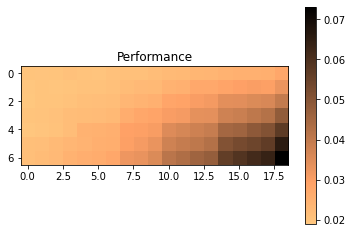

In [2]:
#########  Question 4: #########

## Remark: it will take some time to run the full simulation ##

import timeit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Data_main = pd.read_excel('C:/Files/Software/assesment data engi/gorilla_test_data.xlsx',sheet_name = ['meter_list','forecast_table','rate_table'], engine='openpyxl')

def generateRandomConsumptionList(MeterList, startDate, duration):
    DateList = pd.DataFrame(data = {'date':pd.date_range(start=startDate, periods= duration)})
    dataFrame = pd.merge(MeterList,DateList,how  = 'cross')
    leng = dataFrame.shape[0]
    dataFrame['kwh'] = np.absolute(np.random.normal(0,20 ,size = leng))
    return dataFrame

def generateRandomMeterList(nElements):
    MeterList = Data_main['meter_list']
    MaxEle = MeterList['meter_id'].max()
    Exit_zones = Data_main['rate_table']['exit_zone'].unique()
    
    data = {'meter_id' : np.random.randint(0, high=MaxEle, size=nElements),
        'aq_kwh' : np.random.randint(0, high=MaxEle, size=nElements),
        'exit_zone' : Exit_zones[np.random.choice(range(Exit_zones.size), size=nElements, replace=False)]}
    
    result = pd.DataFrame(data = data)
    return result

# Assumption: Data_main['rate_table'] is loaded into memory and has the correct structure
def generateTransporationCostTable(meterList,consumptionForcastTable):
    result = pd.DataFrame()

    forecast_table = consumptionForcastTable
    result = forecast_table[['meter_id','kwh']].groupby(['meter_id']).sum()

    rate_table_full = pd.merge(
        left=meterList,
        right=Data_main['rate_table'],
        left_on='exit_zone',
        right_on='exit_zone',
        how='outer'
    )
    
    maxAQ = (meterList['aq_kwh']).max()+1
    rate_table_full = rate_table_full.fillna(value = {"aq_max_kwh": maxAQ}).dropna().reset_index(drop = True)

    indexToDrop = np.where(np.less(rate_table_full['aq_kwh'], rate_table_full['aq_min_kwh']) | np.less_equal(rate_table_full['aq_max_kwh'],rate_table_full['aq_kwh']))
    rate_table_full = rate_table_full.drop(index=indexToDrop[0]).reset_index(drop = True)

    maxDate = forecast_table['date'].max() + pd.to_timedelta(1, unit='D') 
    rate_table_full = rate_table_full.drop(index =  np.where(np.less(maxDate,rate_table_full['date']))[0]).reset_index(drop = True)


    rate_table_full.rename(columns={'date': 'date_start'}, inplace = True)
    rate_table_full['date_end'] = rate_table_full['date_start'].shift(-1)
    rate_table_full.loc[np.where(rate_table_full['date_end'] == np.datetime64('2020-04-01'))[0],'date_end'] = maxDate
    rate_table_full.fillna(value = {'date_end': maxDate}, inplace = True)

    forecast_table_full = pd.merge(
        left= forecast_table,
        right= rate_table_full,
        left_on=['meter_id'],
        right_on=['meter_id'],
        how = 'left'
    )

    indexToDrop = np.where(np.less(forecast_table_full['date'], forecast_table_full['date_start']) | np.less_equal(forecast_table_full['date_end'],forecast_table_full['date']))
    forecast_table_full = forecast_table_full.drop(index=indexToDrop[0]).reset_index(drop = True)
    
    forecast_table_full['price_per_day'] = forecast_table_full['kwh']*forecast_table_full['rate_p_per_kwh']/100 
    forecast_table_full_result = forecast_table_full[['meter_id','price_per_day']].groupby(['meter_id']).sum()

    result =  pd.merge(
        left= result,
        right= forecast_table_full_result,
        left_on=['meter_id'],
        right_on=['meter_id'],
        how = 'inner'
    )
    result.rename(columns={'price_per_day': 'Total Cost (£)', 'kwh': 'Total Estimated Consumption(kWh)'}, inplace = True)
    result = result.round(2)
    return result


AmountOfDays = 10
AmountOfMeters = 10

mysetup = '''import timeit
import pandas as pd
import numpy as np
from __main__ import generateRandomMeterList
from __main__ import generateTransporationCostTable
from __main__ import generateRandomConsumptionList

Data_main = pd.read_excel('C:/Files/Software/assesment data engi/gorilla_test_data.xlsx',sheet_name = ['meter_list','forecast_table','rate_table'], engine='openpyxl')
MeterList = generateRandomMeterList(''' + str(AmountOfMeters) + ''')
MeterList_id = MeterList['meter_id']

consumptionForcastTable = generateRandomConsumptionList(MeterList_id,'2020-04-01',''' + str(AmountOfDays) + ''')

'''

mycode = '''
generateTransporationCostTable(MeterList,consumptionForcastTable)
'''

AmountOfSteps = 100
res = []
i = 0

for AmountOfMeters in range(5,40,5):
    res.append([])
    for AmountOfDays in range(50,1000,50):
        mysetup = '''import timeit
import pandas as pd
import numpy as np
from __main__ import generateRandomMeterList
from __main__ import generateTransporationCostTable
from __main__ import generateRandomConsumptionList

Data_main = pd.read_excel('C:/Files/Software/assesment data engi/gorilla_test_data.xlsx',sheet_name = ['meter_list','forecast_table','rate_table'], engine='openpyxl')
MeterList = generateRandomMeterList(''' + str(AmountOfMeters) + ''')
MeterList_id = MeterList['meter_id']

consumptionForcastTable = generateRandomConsumptionList(MeterList_id,'2020-04-01',''' + str(AmountOfDays) + ''')

'''

        mycode = '''
generateTransporationCostTable(MeterList,consumptionForcastTable)
'''
        res[i].append(timeit.timeit(setup = mysetup,stmt = mycode,number = AmountOfSteps)/AmountOfSteps)
    i+=1
#i is printed as status update should reach 9
    print(i)
      
res = np.array(res)

# X axis and Y axis are here the indices
# Y axis amount of meters and X = amount of days

print(res)

im = plt.imshow(res, cmap="copper_r")
plt.colorbar(im)
plt.title('Performance')
plt.show()

### Observations
# In the plot we can see that it scales super linearly in X axis and linearly in the Y axis. this implies the slope in the y axis increases as x increases
# From this we find that the amount of days is the decisive factor for larger datasets 


In [8]:
#########  Question 5: #########

import timeit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Data_main = pd.read_excel('C:/Files/Software/assesment data engi/gorilla_test_data.xlsx',sheet_name = ['meter_list','forecast_table','rate_table'], engine='openpyxl')

def generateRandomConsumptionList(MeterList, startDate, duration):
    DateList = pd.DataFrame(data = {'date':pd.date_range(start=startDate, periods= duration)})
    dataFrame = pd.merge(MeterList,DateList,how  = 'cross')
    leng = dataFrame.shape[0]
    dataFrame['kwh'] = np.absolute(np.random.normal(0,20 ,size = leng))
    return dataFrame

def generateRandomMeterList(nElements):
    MeterList = Data_main['meter_list']
    MaxEle = MeterList['meter_id'].max()
    Exit_zones = Data_main['rate_table']['exit_zone'].unique()
    
    data = {'meter_id' : np.random.randint(0, high=MaxEle, size=nElements),
        'aq_kwh' : np.random.randint(0, high=MaxEle, size=nElements),
        'exit_zone' : Exit_zones[np.random.choice(range(Exit_zones.size), size=nElements, replace=False)]}
    
    result = pd.DataFrame(data = data)
    return result

# Assumption: Data_main['rate_table'] is loaded into memory and has the correct structure
%load_ext line_profiler
def generateTransporationCostTable(meterList,consumptionForcastTable):
    result = pd.DataFrame()

    forecast_table = consumptionForcastTable
    result = forecast_table[['meter_id','kwh']].groupby(['meter_id']).sum()

    rate_table_full = pd.merge(
        left=meterList,
        right=Data_main['rate_table'],
        left_on='exit_zone',
        right_on='exit_zone',
        how='outer'
    )
    
    maxAQ = (meterList['aq_kwh']).max()+1
    rate_table_full = rate_table_full.fillna(value = {"aq_max_kwh": maxAQ}).dropna().reset_index(drop = True)

    indexToDrop = np.where(np.less(rate_table_full['aq_kwh'], rate_table_full['aq_min_kwh']) | np.less_equal(rate_table_full['aq_max_kwh'],rate_table_full['aq_kwh']))
    rate_table_full = rate_table_full.drop(index=indexToDrop[0]).reset_index(drop = True)

    maxDate = forecast_table['date'].max() + pd.to_timedelta(1, unit='D') 
    rate_table_full = rate_table_full.drop(index =  np.where(np.less(maxDate,rate_table_full['date']))[0]).reset_index(drop = True)


    rate_table_full.rename(columns={'date': 'date_start'}, inplace = True)
    rate_table_full['date_end'] = rate_table_full['date_start'].shift(-1)
    rate_table_full.loc[np.where(rate_table_full['date_end'] == np.datetime64('2020-04-01'))[0],'date_end'] = maxDate
    rate_table_full.fillna(value = {'date_end': maxDate}, inplace = True)

    forecast_table_full = pd.merge(
        left= forecast_table,
        right= rate_table_full,
        left_on=['meter_id'],
        right_on=['meter_id'],
        how = 'left'
    )
    
    indexToDrop = np.where(np.less(forecast_table_full['date'], forecast_table_full['date_start']) | np.less_equal(forecast_table_full['date_end'],forecast_table_full['date']))
    forecast_table_full = forecast_table_full.drop(index=indexToDrop[0]).reset_index(drop = True)
    
    forecast_table_full['price_per_day'] = forecast_table_full['kwh']*forecast_table_full['rate_p_per_kwh']/100 
    forecast_table_full_result = forecast_table_full[['meter_id','price_per_day']].groupby(['meter_id']).sum()

    result =  pd.merge(
        left= result,
        right= forecast_table_full_result,
        left_on=['meter_id'],
        right_on=['meter_id'],
        how = 'inner'
    )
    result.rename(columns={'price_per_day': 'Total Cost (£)', 'kwh': 'Total Estimated Consumption(kWh)'}, inplace = True)
    result = result.round(2)
    return result

AmountOfDays   = 100
AmountOfMeters = 35

Data_main = pd.read_excel('C:/Files/Software/assesment data engi/gorilla_test_data.xlsx',sheet_name = ['meter_list','forecast_table','rate_table'], engine='openpyxl')
MeterList = generateRandomMeterList(AmountOfMeters)
MeterList_id = MeterList['meter_id']

consumptionForcastTable = generateRandomConsumptionList(MeterList_id,'2020-04-01',AmountOfDays)

%lprun -f generateTransporationCostTable generateTransporationCostTable(MeterList,consumptionForcastTable)

### Change compare results when amount of days = 100
# Largest contributing factor: 12.6% line 60: create forecast_table_full using merge
# Closely followed by:         10.6% line 37: first merge create rate_table_full
# Closely followed by:         10.5%  line 72: creating forecast_table_full_result by grouping and summing

### Change compare results when amount of days = 800
# Largest contributing factor: 24.9% line 60: create forecast_table_full using merge
# Closely follewed by:         24.2% line 69: dropping of several columns and adding indices to forecast_table_full

# We see clearly that merge done in order to create forecast_table_full has the biggest impact.
# This makes sense since the length of the table is directly proportional to the product of AmountOfDays and AmountOfMeters.
# This implies that one needs to minimize the length of the merged table on which we do the filtering (line 68 on indexToDrop).
# One approach is to make use of then use pd.apply on the days and different range of observations, and thus select the correct rate for each observation.
# Remark that pd.apply is not efficient so, however the super linear behaviour for larger datsets is nog a good sign for scalability 



The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-07 s

Total time: 0.0403654 s

Could not find file C:\Users\Ward\AppData\Local\Temp\ipykernel_13472\2470627421.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                           
    32         1       4806.0   4806.0      1.2  
    33                                           
    34         1         14.0     14.0      0.0  
    35         1      40629.0  40629.0     10.1  
    36                                           
    37         2      42649.0  21324.5     10.6  
    38         1          8.0      8.0      0.0  
    39         1         12.0     12.0      0.0  
    40         1          9.0      9.0      0.0  
    41         1          7.0      7.0      0.0  
    42         1          8.0      8.0      0.0  
    43                                           
    44         